In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import scipy
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import fbpca

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0
import pickle

In [4]:
import graph_learning_utils as gl

# Rewrite algo for faster runs

In [5]:
def objective_with_params_sparse(eta_arr, validation_mat, 
        sample_mats, delta, num_eigs_included=None, verbose=False, use_random_svd=True):
    if num_eigs_included is None:
        num_eigs_included = validation_mat.shape[0]
    P_hat = gl.matrix_lin_combo_pos_sign(eta_arr, sample_mats, sparse=True)

    # singular values, increasing order
    # print('running svd with {} singular values'.format(num_eigs_included))
    if use_random_svd: 
        # print('using random svd with k={}'.format(num_eigs_included))
        # eigvals, _ = fbpca.eigens(validation_mat - P_hat, k = num_eigs_included)
        U, S, Vh = fbpca.pca(validation_mat - P_hat, k = num_eigs_included, n_iter=4)
        diff_sing_values = S
    else: 
        sing_vals = scipy.sparse.linalg.svds(validation_mat - P_hat, solver='arpack',
                                                k=num_eigs_included - 1, return_singular_vectors=False)
        diff_sing_values = np.flip(sing_vals)

    # assumes sing values are in decrasing order
    def ob_fn(k): 
        return sum(diff_sing_values[k:]) - k * delta

    all_obj_values = [ob_fn(k) for k in range(1, num_eigs_included + 1)]
    max_obj_index = np.argmax(all_obj_values)
    # print(all_obj_values, max_obj_index)
    return all_obj_values[max_obj_index]

# Import data

In [6]:
human_ppi_mat = scipy.sparse.load_npz('data/adj_matrix_sparse_restricted_9606.npz')
max_degree =  np.max(human_ppi_mat)
human_ppi_mat /= max_degree

## generate data for run

In [8]:
m = 5 
occlusion_rate = 0.01
occluded_ground_truths = [gl.gen_occluded_p(human_ppi_mat, frac_to_occlude=occlusion_rate) for _ in range(m)]
validation_mat = gl.gen_sparse_sample_boolean_mat(human_ppi_mat)
sample_mats = [gl.gen_sparse_sample_boolean_mat(occluded_ground_truth) for occluded_ground_truth in occluded_ground_truths]

## try BFGS with randomized eigvals

In [11]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500, 
    'ftol': 1e-12, 
    'gtol': 1e-12, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89294D+02    |proj g|=  9.45510D-01
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random svd with k=10
using random sv

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[18.0277161]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 17 instead with accuracy 
4.883691939496698.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[4.88369194]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


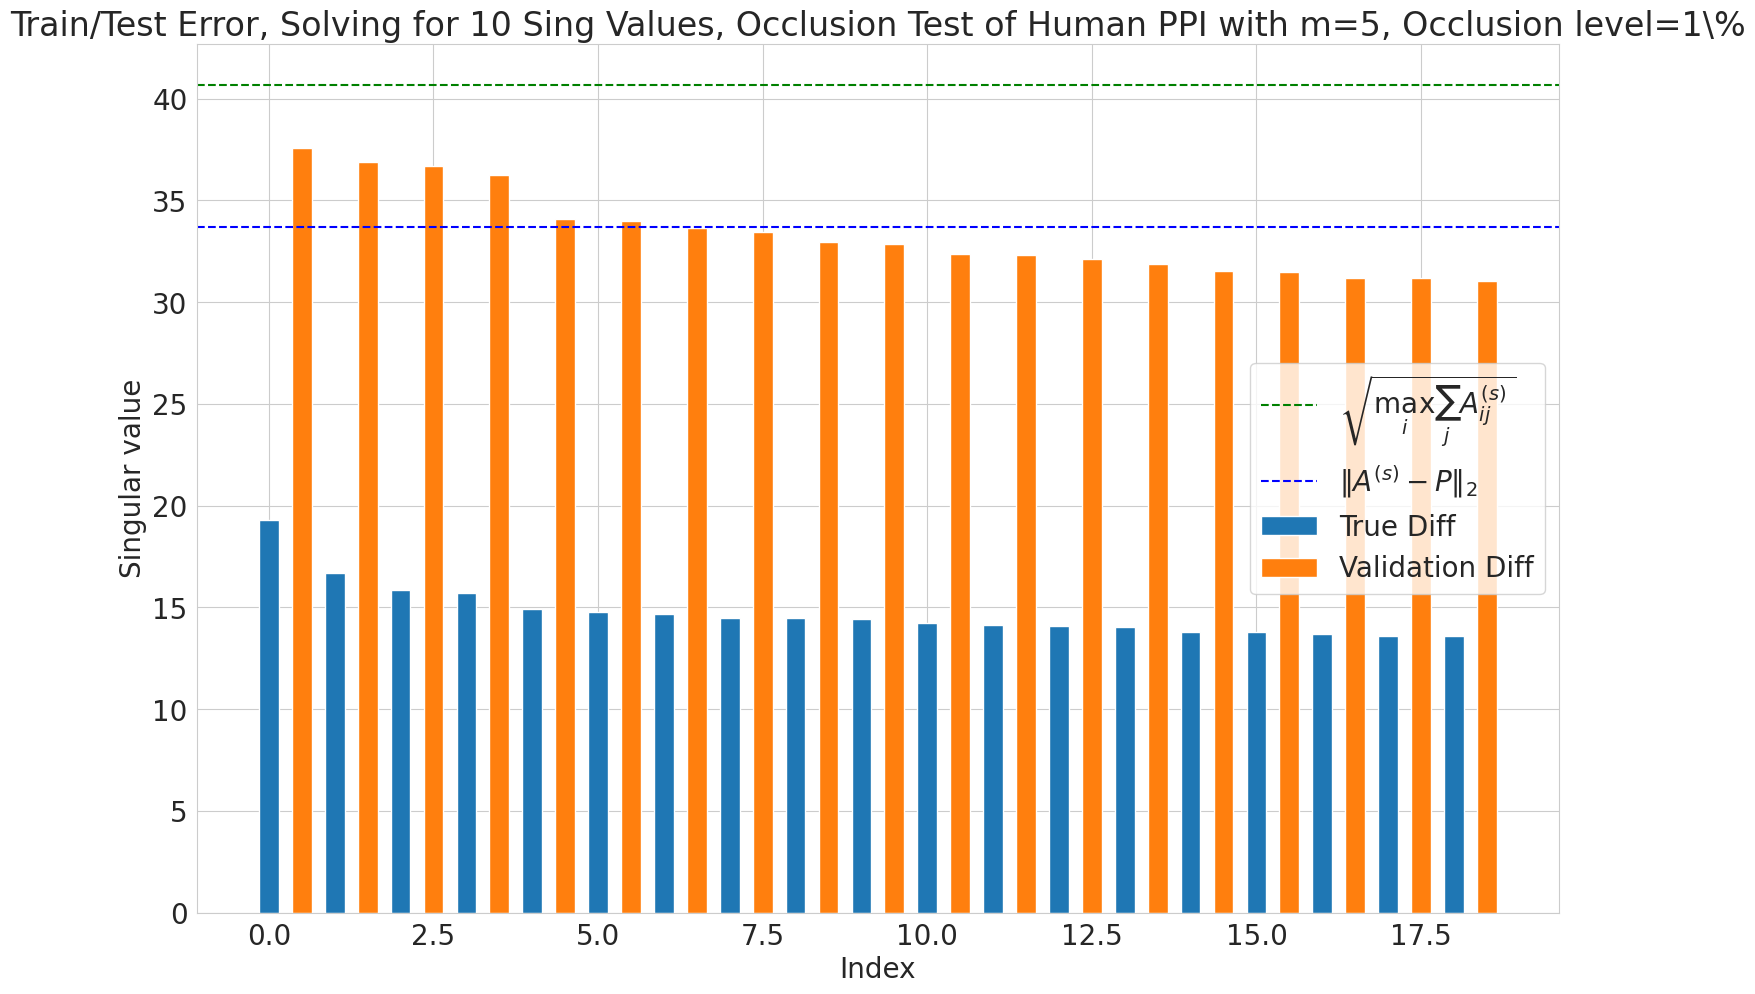

In [13]:
gl.plot_scipy_optimize_result_and_save(result, sample_mats, validation_mat, human_ppi_mat, num_eigs_to_include, 20)

Questions: 

* Why is true error always lower than test error? 

* Why is the true delta so high here? Shouldn't it be much lower? 

* Does using a relatively high delta help in convergence? We used around delta=4 here. 

* Can we use an even smaller ftol/gtol?

In [16]:
result_ftol_1e12 = result.copy()

### bfgs with no ftol setting

In [19]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include, use_random_svd=True)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500
    # 'ftol': 1e-12, 
    # 'gtol': 1e-12, 
}

result = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09325D+02    |proj g|=  9.76206D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      3     25      7     0     0   9.762D-01   3.079D+02
  F =   307.93582245342105     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.3179239]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
2.3179239016093875.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.3179239]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


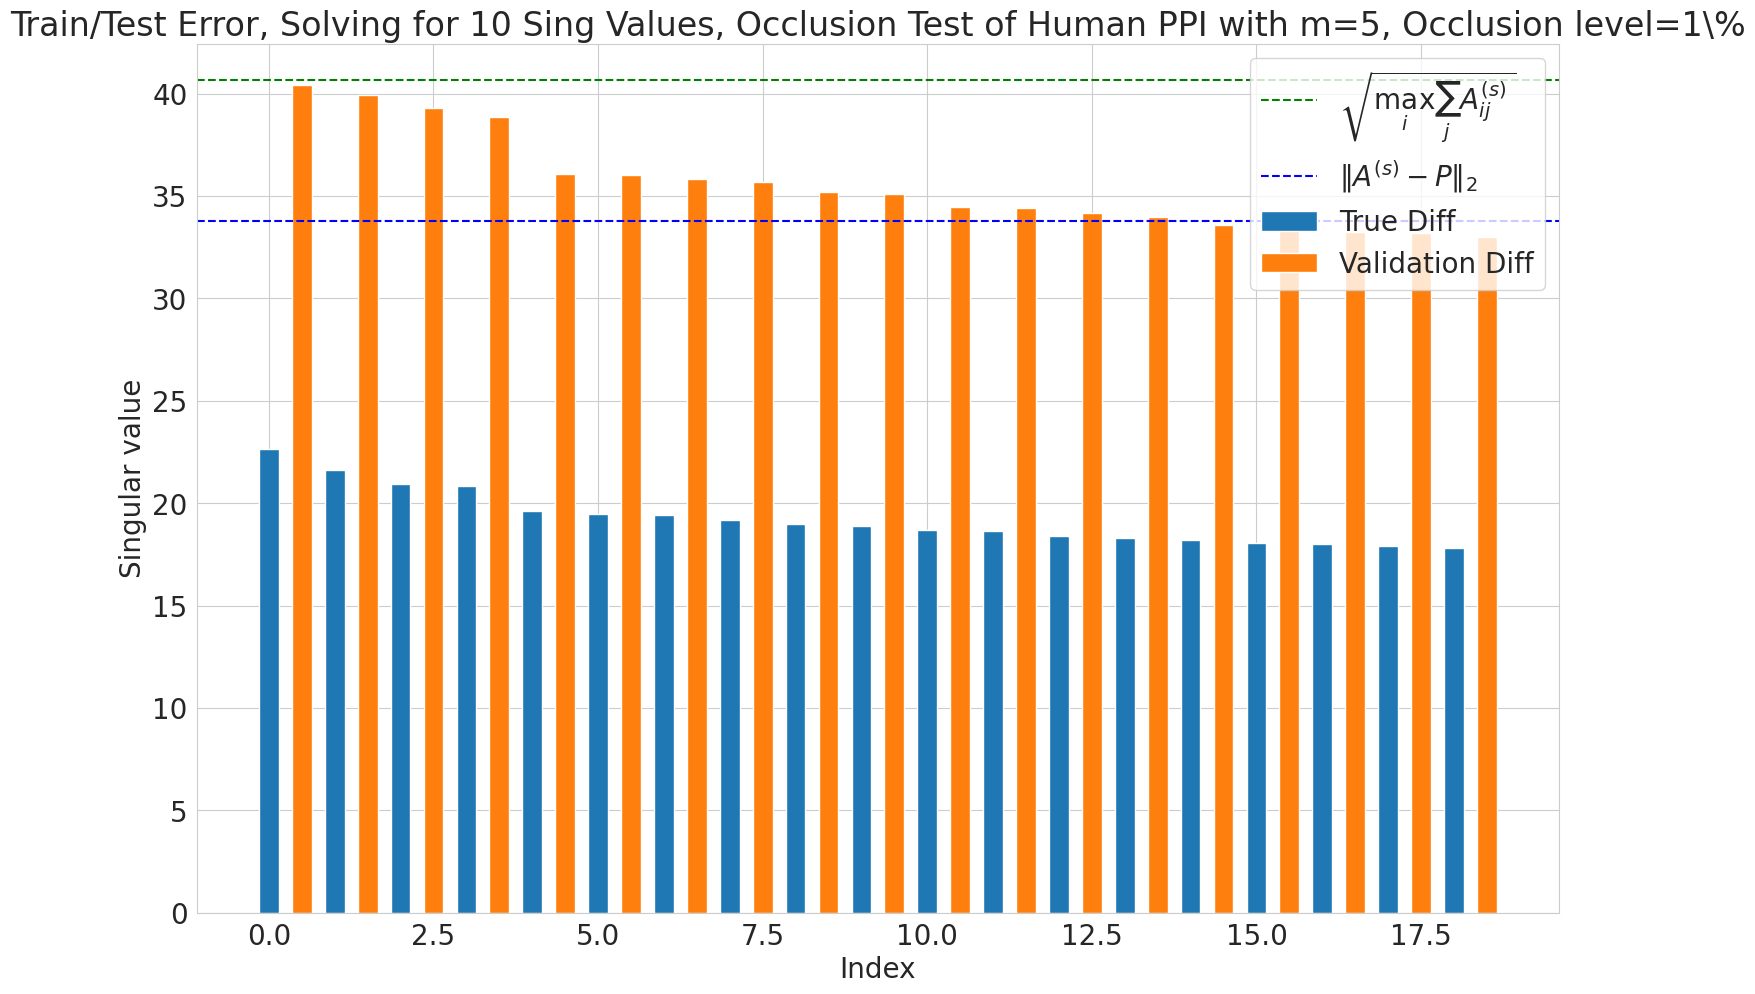

In [20]:
gl.plot_scipy_optimize_result_and_save(result, sample_mats, validation_mat, human_ppi_mat, num_eigs_to_include, 20)

## Better data with hopefully less error

### zero occlusion

In [7]:
m = 10
occlusion_rate = 0.00
occluded_ground_truths = [gl.gen_occluded_p(human_ppi_mat, frac_to_occlude=occlusion_rate) for _ in range(m)]
validation_mat = gl.gen_sparse_sample_boolean_mat(human_ppi_mat)
sample_mats = [gl.gen_sparse_sample_boolean_mat(occluded_ground_truth) for occluded_ground_truth in occluded_ground_truths]

In [8]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include, use_random_svd=True)
bfgs_options = {
    'iprint': 5, 
    'maxiter': 500
    # 'ftol': 1e-12, 
    # 'gtol': 1e-12, 
}

result_no_occlusion = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76622D+02    |proj g|=  9.59712D-01

           * * *




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10      1     20     10     0    10   9.597D-01   2.769D+02
  F =   276.94941111282787     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.73411421]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
2.734114205722114.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.73411421]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


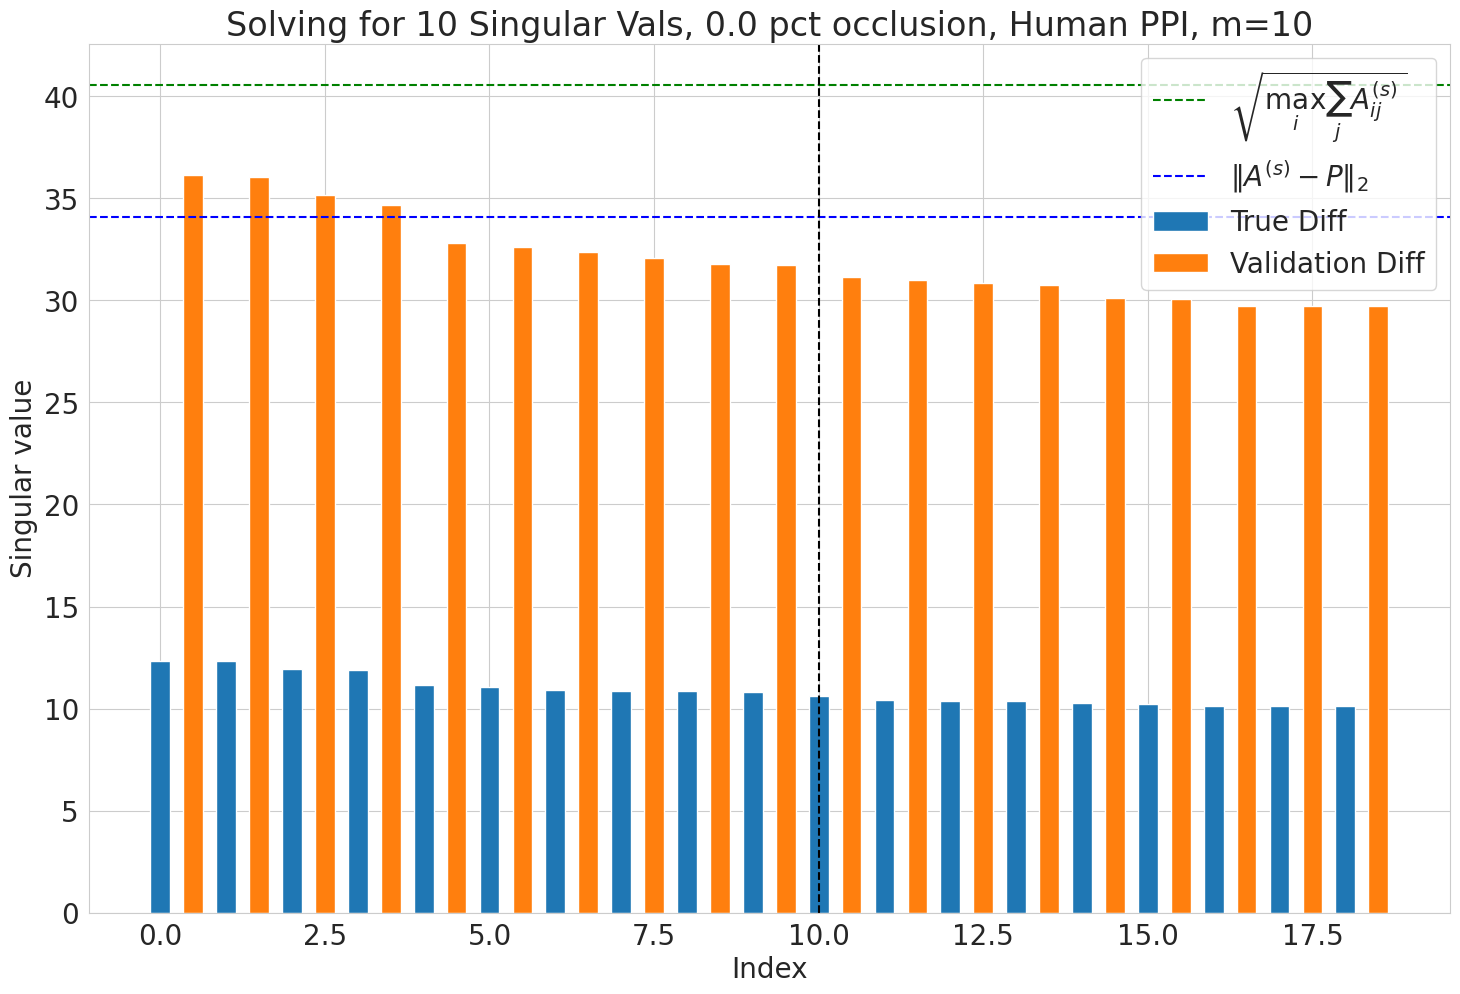

In [11]:
gl.plot_scipy_optimize_result_and_save(result_no_occlusion, sample_mats, validation_mat, 
                                       human_ppi_mat, num_eigs_to_include, 20, m=m, occlusion_level=occlusion_rate)

### huge m

In [12]:
m = 100
occlusion_rate = 0.00
occluded_ground_truths = [gl.gen_occluded_p(human_ppi_mat, frac_to_occlude=occlusion_rate) for _ in range(m)]
validation_mat = gl.gen_sparse_sample_boolean_mat(human_ppi_mat)
sample_mats = [gl.gen_sparse_sample_boolean_mat(occluded_ground_truth) for occluded_ground_truth in occluded_ground_truths]

In [13]:
eta_init = gl.generate_random_eta(m)
delta_scaling = 0.1
delta = gl.delta_estimate(validation_mat, scaling=delta_scaling)
num_eigs_to_include = 10

objective = lambda eta_arr: objective_with_params_sparse(eta_arr, validation_mat, sample_mats, delta, verbose=True, 
                                                         num_eigs_included=num_eigs_to_include, use_random_svd=True)
bfgs_options = {
    'iprint': 2, 
    'maxiter': 500
    # 'ftol': 1e-12, 
    # 'gtol': 1e-12, 
}

result_no_occlusion = scipy.optimize.minimize(
    objective,
    eta_init,
    method='L-BFGS-B',
    jac=None,
    bounds=[(0, 1) for _ in range(len(sample_mats))],
    options=bfgs_options
)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          100     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62855D+02    |proj g|=  9.98480D-01


KeyboardInterrupt: 

# run big job

In [17]:
import jobs1

In [18]:
jobs1.main()

--------------------------

BEGIN TEST at time 04/06/2023, 15:21:04
--------------------------

BEGIN TEST at time 04/06/2023, 15:21:05
Running test with m=5, delta_scaling=0.0, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.91026D+02    |proj g|=  9.24943D-01
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 292.1235538225317
        x: [ 2.586e-01  2.169e-01  7.506e-02  2.026e-01  2.468e-01]
      nit: 1
      jac: [-2.892e+08 -2.206e+08 -3.711e+07  7.850e+07 -7.737e+07]
     nfev: 120
     njev: 20
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
           * * *


Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = numbe


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.42639879]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.4263987930962407.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.42639879]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.397977450400155
Top 20 validation diff singular values [30.86569604 30.94449648 31.02797135 31.47691024 31.690823   31.75641802
 31.98147861 32.15110066 32.45805364 32.91667807 33.14268056 33.19998903
 33.48435593 33.50726717 33.84133453 36.00761664 36.41835765 37.90504532
 38.00153337]
Top 20 v true diff singular values [13.1956799  13.20483859 13.22947602 13.29574198 13.40634229 13.52080437
 13.60215724 13.67228547 13.79958417 13.87214616 13.92766856 14.19751442
 14.31005948 14.35669223 14.48496167 15.4454262  15.49811765 16.16574776
 16.20618126]
END TEST at time 04/06/2023, 15:22:51
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:22:51
Running test with m=5, delta_scaling=0.0, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.95244D

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.65391781]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
2.653917812080514.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.65391781]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.8207481492309
Top 20 validation diff singular values [31.16140922 31.29615645 31.49175615 31.5922059  31.89877362 31.93513611
 32.08071889 32.53583891 32.70968249 32.88475876 33.04682523 33.07132458
 33.18066273 34.11467171 34.28176215 36.98364387 37.03574827 37.25857185
 37.36537311]
Top 20 v true diff singular values [13.83451812 13.9383322  14.04019774 14.10914086 14.24137346 14.31312149
 14.36646201 14.44223801 14.62274952 14.6278785  14.64264791 14.84153501
 15.01678414 15.16754959 16.19284811 16.28367519 16.70932984 16.82667978
 18.67924242]
END TEST at time 04/06/2023, 15:25:06
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:25:06
Running test with m=5, delta_scaling=0.0, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28134D+02

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.04173182]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
2.0417318183675794.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.04173182]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.49177533093767
Top 20 validation diff singular values [32.0003617  32.43235295 32.45020575 32.6473275  32.73122672 33.25126908
 33.40755993 33.64541876 34.06496926 34.50544314 34.9580298  36.07178502
 36.53559161 36.8964614  37.89235768 38.13247564 38.59554266 49.72289231
 68.04244813]
Top 20 v true diff singular values [17.09383858 17.5592775  17.63862214 17.7872943  18.19976712 18.7222995
 20.21584401 20.90052743 21.72286082 22.38392103 23.70750368 23.79547242
 24.47419709 25.61815123 27.4112607  30.85811499 32.11599892 44.80186632
 64.11305114]
END TEST at time 04/06/2023, 15:29:57
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:29:57
Running test with m=5, delta_scaling=0.0, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.62671D+02

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[4.46614818]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
4.466148181423185.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[4.46614818]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.05439060963676
Top 20 validation diff singular values [ 46.23291022  47.56849752  50.34313298  50.92127532  52.6946277
  54.53554043  56.32857403  59.05478422  61.33192911  66.22767286
  66.27733032  72.02142245  74.2494688   76.14870966  83.71965583
  94.89623739  99.65265656 137.24611726 197.32545435]
Top 20 v true diff singular values [ 42.51807881  44.50463114  46.72532767  47.39064829  49.24989453
  51.28992396  53.0190052   55.9885169   58.56564851  63.4390322
  64.14153935  69.51976114  72.28060281  73.76925285  81.67411286
  92.72609544  98.33153938 135.58897761 195.22035375]
END TEST at time 04/06/2023, 15:31:23
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:31:23
Running test with m=5, delta_scaling=0.1, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bound


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.26978868]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 15 instead with accuracy 
0.6923166134525517.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.69231661]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.5428814419471
Top 20 validation diff singular values [30.89874978 30.95072465 30.98665452 31.13588056 31.34269944 31.58877247
 31.70553598 32.08622028 32.18914685 33.20031563 33.36742511 33.37911997
 33.54794434 33.7771972  34.11626671 36.4377563  36.55277566 36.72744826
 37.01337164]
Top 20 v true diff singular values [13.36289267 13.42797667 13.49761588 13.52482481 13.57932323 13.73829365
 13.82402424 13.94402366 14.09055264 14.30313234 14.30585597 14.53402975
 14.53992708 14.69020729 14.73824983 15.63263337 15.63723269 16.22081692
 16.37650006]
END TEST at time 04/06/2023, 15:33:13
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:33:13
Running test with m=5, delta_scaling=0.1, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.89329D+0


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.36631421]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.3663142055802817.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.36631421]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.18500204841235
Top 20 validation diff singular values [31.3198955  31.58392256 31.58692108 31.97215859 32.09757484 32.43386483
 32.55178757 32.74526549 32.76933473 32.90194514 33.12199049 33.37011108
 33.75590212 34.3461086  34.41413719 36.79235458 37.19766261 37.86330152
 38.16303196]
Top 20 v true diff singular values [13.91390703 13.93209964 14.21288526 14.23409234 14.36094274 14.36838029
 14.59013544 14.72787326 14.78129054 14.93176161 15.19111577 15.2777223
 15.90626191 16.01007698 16.07547345 16.28067389 16.94735006 17.05433617
 19.55667299]
END TEST at time 04/06/2023, 15:35:29
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:35:29
Running test with m=5, delta_scaling=0.1, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.58634D+02

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.19572306]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.1957230594296955.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.19572306]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.16602719778906
Top 20 validation diff singular values [34.99475136 35.33084206 35.57624648 35.6568482  35.94634078 36.01337519
 36.06176298 36.54496392 36.55788923 37.28522562 38.78669434 39.08514112
 39.90885551 40.38800726 40.7366429  44.69995229 44.77656016 56.71439371
 75.39301666]
Top 20 v true diff singular values [21.4712082  21.63836416 21.76898891 21.86849595 23.02464383 23.56300689
 23.6881849  25.03707639 26.38485796 26.6752404  28.60625579 29.26479579
 29.37200064 31.99440513 34.11358294 38.7144783  40.11568335 52.96101892
 71.93526588]
END TEST at time 04/06/2023, 15:37:42
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:37:42
Running test with m=5, delta_scaling=0.1, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61522D+0

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.33546238]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 20 instead with accuracy 
0.23931540976240195.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.23931541]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.06705327498312
Top 20 validation diff singular values [ 46.17427257  48.00749299  49.20302795  50.64462898  52.25844823
  54.05202303  56.15699216  59.06446798  60.79912447  65.63241124
  66.70124983  71.57783652  74.57378907  76.70245146  83.90685185
  95.79470747 101.15937293 135.95372992 197.54364848]
Top 20 v true diff singular values [ 42.57872152  44.56955449  45.98818942  47.30401435  49.25401207
  50.99671724  52.89281502  56.27757568  58.00970364  62.87390856
  64.36001042  69.0937829   72.15262042  74.42453237  81.51952972
  93.85621149  99.44981105 134.77261814 196.56848842]
END TEST at time 04/06/2023, 15:39:18
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:39:18
Running test with m=5, delta_scaling=0.5, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bou

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.40117832]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.4011783232902588.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.40117832]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.310208854291034
Top 20 validation diff singular values [31.91985599 32.00915209 32.28265677 32.31440928 32.71957254 33.11950563
 33.13387708 33.30757451 33.46468221 34.07139319 34.51124634 34.93021917
 35.05464266 35.40746255 35.56190065 37.28955832 37.70810199 38.99223015
 39.04222589]
Top 20 v true diff singular values [15.59707965 15.70132369 15.79356313 15.94822387 16.02454566 16.08555237
 16.28712904 16.41080128 16.71055217 16.71623857 16.86776899 17.06775366
 17.10569998 17.21768516 17.26083    18.25468592 18.51279963 18.78773004
 18.96613027]
END TEST at time 04/06/2023, 15:41:58
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:41:58
Running test with m=5, delta_scaling=0.5, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88510D


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.37194158]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.3719415752819212.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.37194158]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.330351394931526
Top 20 validation diff singular values [32.80145939 32.81182764 32.97708632 33.07036918 33.15328314 33.98966426
 34.09295817 34.38937892 34.56921758 34.98772288 35.16711708 35.24699581
 35.39632564 35.74553572 35.84475726 38.17635116 38.32227375 40.56603927
 40.69161307]
Top 20 v true diff singular values [17.2585579  17.51169337 17.60545414 17.76220759 17.96554265 18.18833098
 18.25925239 18.3714867  18.50024155 18.60399713 18.86769768 19.07030057
 19.3024228  19.45673844 20.25269709 20.34837873 20.67560329 21.13433378
 22.39933024]
END TEST at time 04/06/2023, 15:44:31
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:44:31
Running test with m=5, delta_scaling=0.5, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.09409D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[8.17609997]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 14 instead with accuracy 
2.607287719294274.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.60728772]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.92827774202614
Top 20 validation diff singular values [32.39937951 32.79655046 32.83507502 32.87497797 33.24759498 33.28859813
 33.53214409 34.0880101  34.33089516 34.93743491 34.93780808 35.93390988
 36.59651726 37.39623475 37.89590109 38.06362254 40.64502215 50.98708491
 71.62848426]
Top 20 v true diff singular values [17.36383599 17.4865007  18.10849677 18.19695401 18.62781313 18.89304765
 20.24281399 20.88820057 21.64876684 22.34289675 23.97163965 24.626738
 25.42733696 26.50552946 28.36456717 32.46899482 35.65121587 47.31302301
 67.65230275]
END TEST at time 04/06/2023, 15:46:37
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:46:37
Running test with m=5, delta_scaling=0.5, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54173D+02 

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.52031035]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.520310349653929.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.52031035]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.303284505991655
Top 20 validation diff singular values [ 46.44775139  47.84266534  49.37012648  50.34253682  52.52689026
  54.25682641  55.80481416  59.09451755  61.25413589  66.32664858
  67.52559196  72.74085577  75.19692031  77.41549087  84.62266431
  97.81569813 101.06677765 139.4176005  200.46704014]
Top 20 v true diff singular values [ 42.51686509  44.77005318  46.22384002  46.88896699  49.47350745
  51.59832878  53.01061529  56.47410219  58.57027675  63.90093066
  65.0416514   70.65946024  72.98897443  75.19232491  82.6460378
  96.23683117  99.5502063  137.92237914 199.13016754]
END TEST at time 04/06/2023, 15:48:31
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:48:31
Running test with m=10, delta_scaling=0.0, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bo


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.41281139]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.41281138853644495.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.41281139]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.35352760067123
Top 20 validation diff singular values [30.06104527 30.15842555 30.20194208 30.34534925 30.36425319 30.84692181
 31.12120415 31.19753999 31.57649975 31.59641479 32.14184688 32.38852768
 32.41759668 32.81471457 33.43045356 35.36301987 35.47626132 36.98791309
 37.05091072]
Top 20 v true diff singular values [11.04077397 11.05818215 11.08434552 11.11813976 11.32989158 11.42071208
 11.47684439 11.51350901 11.53992645 11.68476822 11.78293352 11.91959082
 12.08000236 12.12054024 12.1337626  13.01964301 13.22117256 13.44971098
 13.48682687]
END TEST at time 04/06/2023, 15:54:50
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 15:54:50
Running test with m=10, delta_scaling=0.0, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.82772D

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[4.14031214]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 12 instead with accuracy 
2.4238674670256413.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.42386747]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.24283279390621
Top 20 validation diff singular values [29.91872638 29.94885394 30.20191943 30.20607631 30.26936499 30.93157516
 30.9766177  31.49500146 31.58090218 31.6407792  32.1996816  32.37283734
 32.55420842 32.7173819  32.79514593 34.98366167 35.16093703 36.60028947
 36.85196931]
Top 20 v true diff singular values [10.47640582 10.58153175 10.59670351 10.75284046 10.81566285 10.82813464
 10.92043213 11.03731734 11.24327878 11.28497025 11.30866517 11.3612632
 11.78776293 12.00610702 12.3996635  12.42985555 12.94759319 12.95820006
 16.00661777]
END TEST at time 04/06/2023, 16:01:41
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:01:41
Running test with m=10, delta_scaling=0.0, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.05318D+0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[2.41465007]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 20 instead with accuracy 
2.121408203881825.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[2.1214082]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.34848972273908
Top 20 validation diff singular values [30.38537932 30.83982702 30.88079309 31.06413856 31.18118793 31.70627893
 31.86789406 32.08823555 32.16709756 32.40754368 32.51715376 34.35719949
 34.53980585 34.79175715 35.51357717 36.3708586  36.37928682 45.69256649
 61.79036183]
Top 20 v true diff singular values [14.2633239  14.67556334 15.23673762 15.44071254 15.54649453 15.74307989
 16.82932114 17.72613545 18.40092233 19.55990711 19.8192575  21.27293851
 22.15806551 22.72660436 24.87943091 28.84427395 29.14168885 40.86302165
 58.03758836]
END TEST at time 04/06/2023, 16:08:08
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:08:08
Running test with m=10, delta_scaling=0.0, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58916D+

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.44983768]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.4498376788644328.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.44983768]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.10626964518577
Top 20 validation diff singular values [ 45.80989856  47.97290308  48.52081227  49.81271825  51.47345341
  53.14965068  54.96063735  57.79349925  59.6467827   64.15788454
  66.10070846  71.7971104   73.8332024   75.86754476  83.16753069
  95.53223416 100.92797422 134.65807315 193.35857535]
Top 20 v true diff singular values [ 41.94493139  44.12263453  45.21356382  46.20646055  48.631604
  50.42330409  51.93429845  55.09451341  56.98710182  61.86203238
  63.61965812  69.20932815  71.77789272  73.01407966  81.32268089
  93.28749783  99.05653998 133.02622602 192.69322054]
END TEST at time 04/06/2023, 16:11:25
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:11:25
Running test with m=10, delta_scaling=0.1, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the boun

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[4.0600245]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 15 instead with accuracy 
3.9479893469618763.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[3.94798935]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.248720290269056
Top 20 validation diff singular values [29.64097989 29.68914122 29.76718944 30.04729419 30.14684056 30.53571183
 30.53931738 30.71724042 30.84247358 31.78475916 31.85471101 32.23919111
 32.53259311 32.55153566 32.71665625 35.49832089 35.52854747 36.19885563
 36.46055367]
Top 20 v true diff singular values [10.04412275 10.12335576 10.18065647 10.2626599  10.33796875 10.44205413
 10.4749342  10.49809954 10.59763192 10.66658227 10.73289798 10.77080585
 10.88130592 10.99503313 11.09119667 11.7908331  11.80477058 12.40266243
 12.42176013]
END TEST at time 04/06/2023, 16:18:50
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:18:50
Running test with m=10, delta_scaling=0.1, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.76273

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[5.79420238]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 17 instead with accuracy 
3.981297583245086.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[3.98129758]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.709911928853195
Top 20 validation diff singular values [29.6090221  29.78903901 29.85876827 29.89329184 30.10075919 30.51683687
 30.74925748 31.37565942 31.41162356 31.53749396 31.67819958 31.8401814
 31.85898961 32.43127437 32.52302984 34.70406409 35.28359937 35.86765474
 35.90233022]
Top 20 v true diff singular values [10.29360413 10.3068123  10.4810131  10.59515206 10.62441831 10.67543011
 10.70733814 10.78796312 10.95127672 10.99853563 11.0322166  11.07853275
 11.26180942 11.40797789 11.99781216 12.10221437 12.51665595 12.52272645
 14.12786319]
END TEST at time 04/06/2023, 16:24:34
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:24:34
Running test with m=10, delta_scaling=0.1, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00789D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.13177571]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 20 instead with accuracy 
1.0050007907470426.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.00500079]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.86264964096158
Top 20 validation diff singular values [30.46425253 30.74422535 31.01984228 31.0772176  31.41988099 31.63198973
 32.04633054 32.19210979 32.55798038 32.73521932 32.79255388 33.88199546
 35.09674832 35.249706   35.6297043  35.8551953  35.88174298 45.70117728
 63.77541949]
Top 20 v true diff singular values [14.22107533 14.32306972 14.82677827 15.24266716 15.69004775 16.00748638
 16.90737221 17.25814997 17.94003313 19.50830008 20.390181   21.10373084
 22.55079116 23.08091899 25.34391558 28.53377423 29.72647299 41.09605552
 59.59166205]
END TEST at time 04/06/2023, 16:28:40
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:28:40
Running test with m=10, delta_scaling=0.1, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.55602D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.06414384]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.06414384122008471.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.06414384]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.34680369963416
Top 20 validation diff singular values [ 45.25016431  46.93140682  48.20042994  50.03825685  51.6067641
  53.81322686  55.62119573  57.58853633  59.57704563  64.74838234
  65.94187595  70.92056223  74.51003274  75.77524822  82.40206871
  94.64465194 102.35761559 135.30043893 195.78479304]
Top 20 v true diff singular values [ 41.82812372  43.7954358   44.89178331  46.4556631   48.39479163
  51.05806128  52.38519758  54.53687149  56.7588231   62.45486644
  63.39322732  68.28207965  72.26015539  72.93828657  80.39790772
  92.62393669 100.64355533 133.48082324 194.45371477]
END TEST at time 04/06/2023, 16:33:34
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:33:34
Running test with m=10, delta_scaling=0.5, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bou


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.27614702]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.2761470177828602.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.27614702]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.422088775027696
Top 20 validation diff singular values [29.5380128  29.61031885 29.63839303 29.81301025 29.87292624 30.22674006
 30.58511203 30.91449386 31.13331345 31.57962661 31.62959532 32.18234238
 32.30852603 32.60602938 32.80030206 35.13633577 35.33620617 36.79304206
 36.89125717]
Top 20 v true diff singular values [10.05040553 10.06043757 10.11755515 10.12331258 10.12869032 10.32997961
 10.40392852 10.49169872 10.50983415 10.73979832 10.77281504 10.77848693
 10.83405303 10.9292757  11.05332583 11.73397985 11.80471783 12.40369267
 12.48136288]
END TEST at time 04/06/2023, 16:41:00
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:41:00
Running test with m=10, delta_scaling=0.5, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59692

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.02303137]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.02303137458655545.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.02303137]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.36809556106291
Top 20 validation diff singular values [29.68196876 29.79385521 29.8506454  29.9575981  30.11447606 30.26989956
 30.44825251 30.64707325 30.78725872 31.28722643 31.37325936 31.63966861
 31.94713128 32.18232502 32.61125548 34.66027286 34.80213316 35.95723356
 36.34553268]
Top 20 v true diff singular values [ 9.71552138  9.77270828  9.96673342  9.99449954 10.01501075 10.08738957
 10.13673019 10.17511867 10.30687803 10.48609331 10.53004873 10.61207373
 10.76685719 10.94652775 11.57087918 11.63578053 11.82198571 11.83561709
 14.11241163]
END TEST at time 04/06/2023, 16:51:29
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:51:29
Running test with m=10, delta_scaling=0.5, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.87653D+

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.74203139]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
0.7420313899961443.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.74203139]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.40467507723734
Top 20 validation diff singular values [30.72750603 30.87118873 31.2864695  31.31368462 31.46284534 31.65717622
 31.90967238 31.92941512 32.17024664 32.90539852 32.92208775 34.65044357
 35.10463362 35.41059871 35.8513074  36.46162203 36.65133422 44.98004129
 62.10013973]
Top 20 v true diff singular values [14.63289386 15.34012578 15.60506097 16.00707425 16.41249747 16.79885946
 17.88155384 18.05743339 18.86626145 19.65769656 20.69972243 22.32043363
 23.20580848 23.8279648  25.19909921 29.38063277 30.5376395  41.04460104
 58.99920646]
END TEST at time 04/06/2023, 16:57:29
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 16:57:29
Running test with m=10, delta_scaling=0.5, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38739D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[0.37613003]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 17 instead with accuracy 
0.35323281771772586.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[0.35323282]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.278643527990205
Top 20 validation diff singular values [ 45.63709097  47.03504275  49.42770257  50.08247672  51.8331344
  54.22960253  55.80858746  58.07164093  60.75496333  66.03869381
  66.3236278   71.45612219  73.80012142  76.21356063  82.13200495
  95.11137681 100.48136088 134.06523654 195.88274867]
Top 20 v true diff singular values [ 41.98867331  43.7896798   45.82636977  46.64748814  48.55700322
  51.28657288  52.59872012  55.51123963  58.08683798  63.16133917
  63.78130827  68.78167179  71.99074308  73.61687143  80.05378648
  92.88456817  98.50757905 132.72586453 194.79203372]
END TEST at time 04/06/2023, 17:01:27
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:01:27
Running test with m=15, delta_scaling=0.0, occlusion level=0.0, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bo

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[4.57434502]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 20 instead with accuracy 
3.442508960291655.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[3.44250896]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.71398828119209
Top 20 validation diff singular values [29.16871546 29.23219582 29.28236656 29.4604722  29.46401258 29.83611079
 30.06611304 30.32714865 30.45840804 30.93938622 31.22709775 31.47979156
 31.6699359  31.8053555  31.8969462  34.24138878 34.31861414 35.81884655
 36.17111157]
Top 20 v true diff singular values [7.95404078 7.97704139 8.04151363 8.05049396 8.13587804 8.19342716
 8.2140594  8.2217242  8.31316827 8.47956146 8.56238615 8.60186082
 8.67692699 8.7216181  8.72978817 9.22029958 9.22668785 9.71722528
 9.73341712]
END TEST at time 04/06/2023, 17:11:36
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:11:36
Running test with m=15, delta_scaling=0.0, occlusion level=0.01, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.73844D+02    |proj g|=  9

/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.37624909]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.3762490907793645.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.37624909]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 33.850827667138006
Top 20 validation diff singular values [29.01062915 29.23152104 29.34293586 29.4034604  29.6563971  29.89919575
 30.32099412 30.56645902 30.70754038 30.75955474 30.89850485 31.29438596
 31.31416123 31.66467765 31.77875736 33.72035428 34.1908214  34.49901219
 34.9236187 ]
Top 20 v true diff singular values [ 7.79632623  7.82600828  7.91709987  7.92741288  7.95217059  8.07009502
  8.18319845  8.21868145  8.34686062  8.4222339   8.46210693  8.48337726
  8.60250821  8.9605713   9.15615372  9.18099581  9.44940631  9.4818923
 11.6589441 ]
END TEST at time 04/06/2023, 17:20:56
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:20:56
Running test with m=15, delta_scaling=0.0, occlusion level=0.1, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00702D+


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited at iteration 20 with accuracies 
[1.79049629]
not reaching the requested tolerance 0.00017756223678588867.
Use iteration 21 instead with accuracy 
1.790496286977265.

  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,
/home/akhil/miniconda3/envs/py3-akhil/lib/python3.10/site-packages/scipy/sparse/linalg/_eigen/_svds.py:491: UserWarning: Exited postprocessing with accuracies 
[1.79049629]
not reaching the requested tolerance 0.00017756223678588867.
  _, eigvec = lobpcg(XH_X, X, tol=tol ** 2, maxiter=maxiter,


L2 diff of validation and ground truth 34.21468783646521
Top 20 validation diff singular values [30.04945705 30.20648779 30.21963371 30.50003563 30.50128386 31.03936992
 31.31941039 31.67789865 32.05633655 32.25620571 32.52700073 32.8594412
 34.22535262 34.75794438 34.85713547 35.50188468 35.58086278 43.43649673
 59.7520984 ]
Top 20 v true diff singular values [12.81742792 13.01213733 13.47853442 14.25456818 14.62875991 14.81361641
 15.36674706 16.16109977 16.82357844 18.15401675 18.70838082 19.87905584
 20.38338643 21.61566139 22.79411626 26.5833294  27.65197704 38.34056977
 55.35024779]
END TEST at time 04/06/2023, 17:32:06
--------------------------

--------------------------

BEGIN TEST at time 04/06/2023, 17:32:06
Running test with m=15, delta_scaling=0.0, occlusion level=0.5, k=10
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49719D+0

# things to plot from this big run

* What is the performance of the (sum of top s singular values of) true diff, as a function of m, fraction occluded? 

x axis: m 
y axis: performance
split out by: fraction occluded 

(Maybe normalize each score by the true L2 diff of A^(s) and P, just to get a sense of the )

* Histogram of the L2 diff of A^(s) and P over time "true delta" versus the "estimated delta" with C = 1. 